In [ ]:
!pip install lime
!pip install SHAP

In [4]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import datetime
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import lime
from lime.lime_tabular import LimeTabularExplainer
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
#import matplotlib as plt
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']= 300

### Loading data

In [3]:
filepath = 'https://raw.githubusercontent.com/mh2t/RiskyDealer/main/case.csv'
df = pd.read_csv(filepath, sep=',')

In [49]:
print(df.shape)

(2348, 291)


### Feature Selection

In [4]:
#remove features not used for modeling
del df['BuyerID']
del df['Returned']
df = df.dropna(0)

### Feature Engineering

In [5]:
### Set target variable and remove it from input variable list
df_y = df['Risky']
del df['Risky']

### Data preparation for tree model: 

In [6]:
### Split into training and test dataset
len_train = len(df)
x = df[:len_train]
y = df_y[:len_train]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.33, random_state=42)
holdout_x = df[len_train:]
holdout_y = df_y[len_train:]

# Lasso Logistic Regression 

In [11]:
scaler = StandardScaler()
scaler.fit(train_x)
clf = LogisticRegressionCV(fit_intercept=True, cv=5, penalty='l1', scoring='roc_auc', solver='liblinear', 
                           tol=0.0001, max_iter=100, refit=True, random_state=42).fit(scaler.transform(train_x), train_y)

In [13]:
clf.score(scaler.transform(train_x), train_y)

0.8253513726949071

In [14]:
clf.score(scaler.transform(test_x), test_y)

0.7956259426847662

In [26]:
np.sum(clf.coef_ != 0)

65

In [15]:
sel_feats = train_x.columns[(clf.coef_ != 0).ravel().tolist()]

In [225]:
coefs = pd.DataFrame(np.transpose(clf.coef_), df.columns, columns=['Coefficients'])
coefs = coefs.iloc[coefs.Coefficients.abs().argsort()]

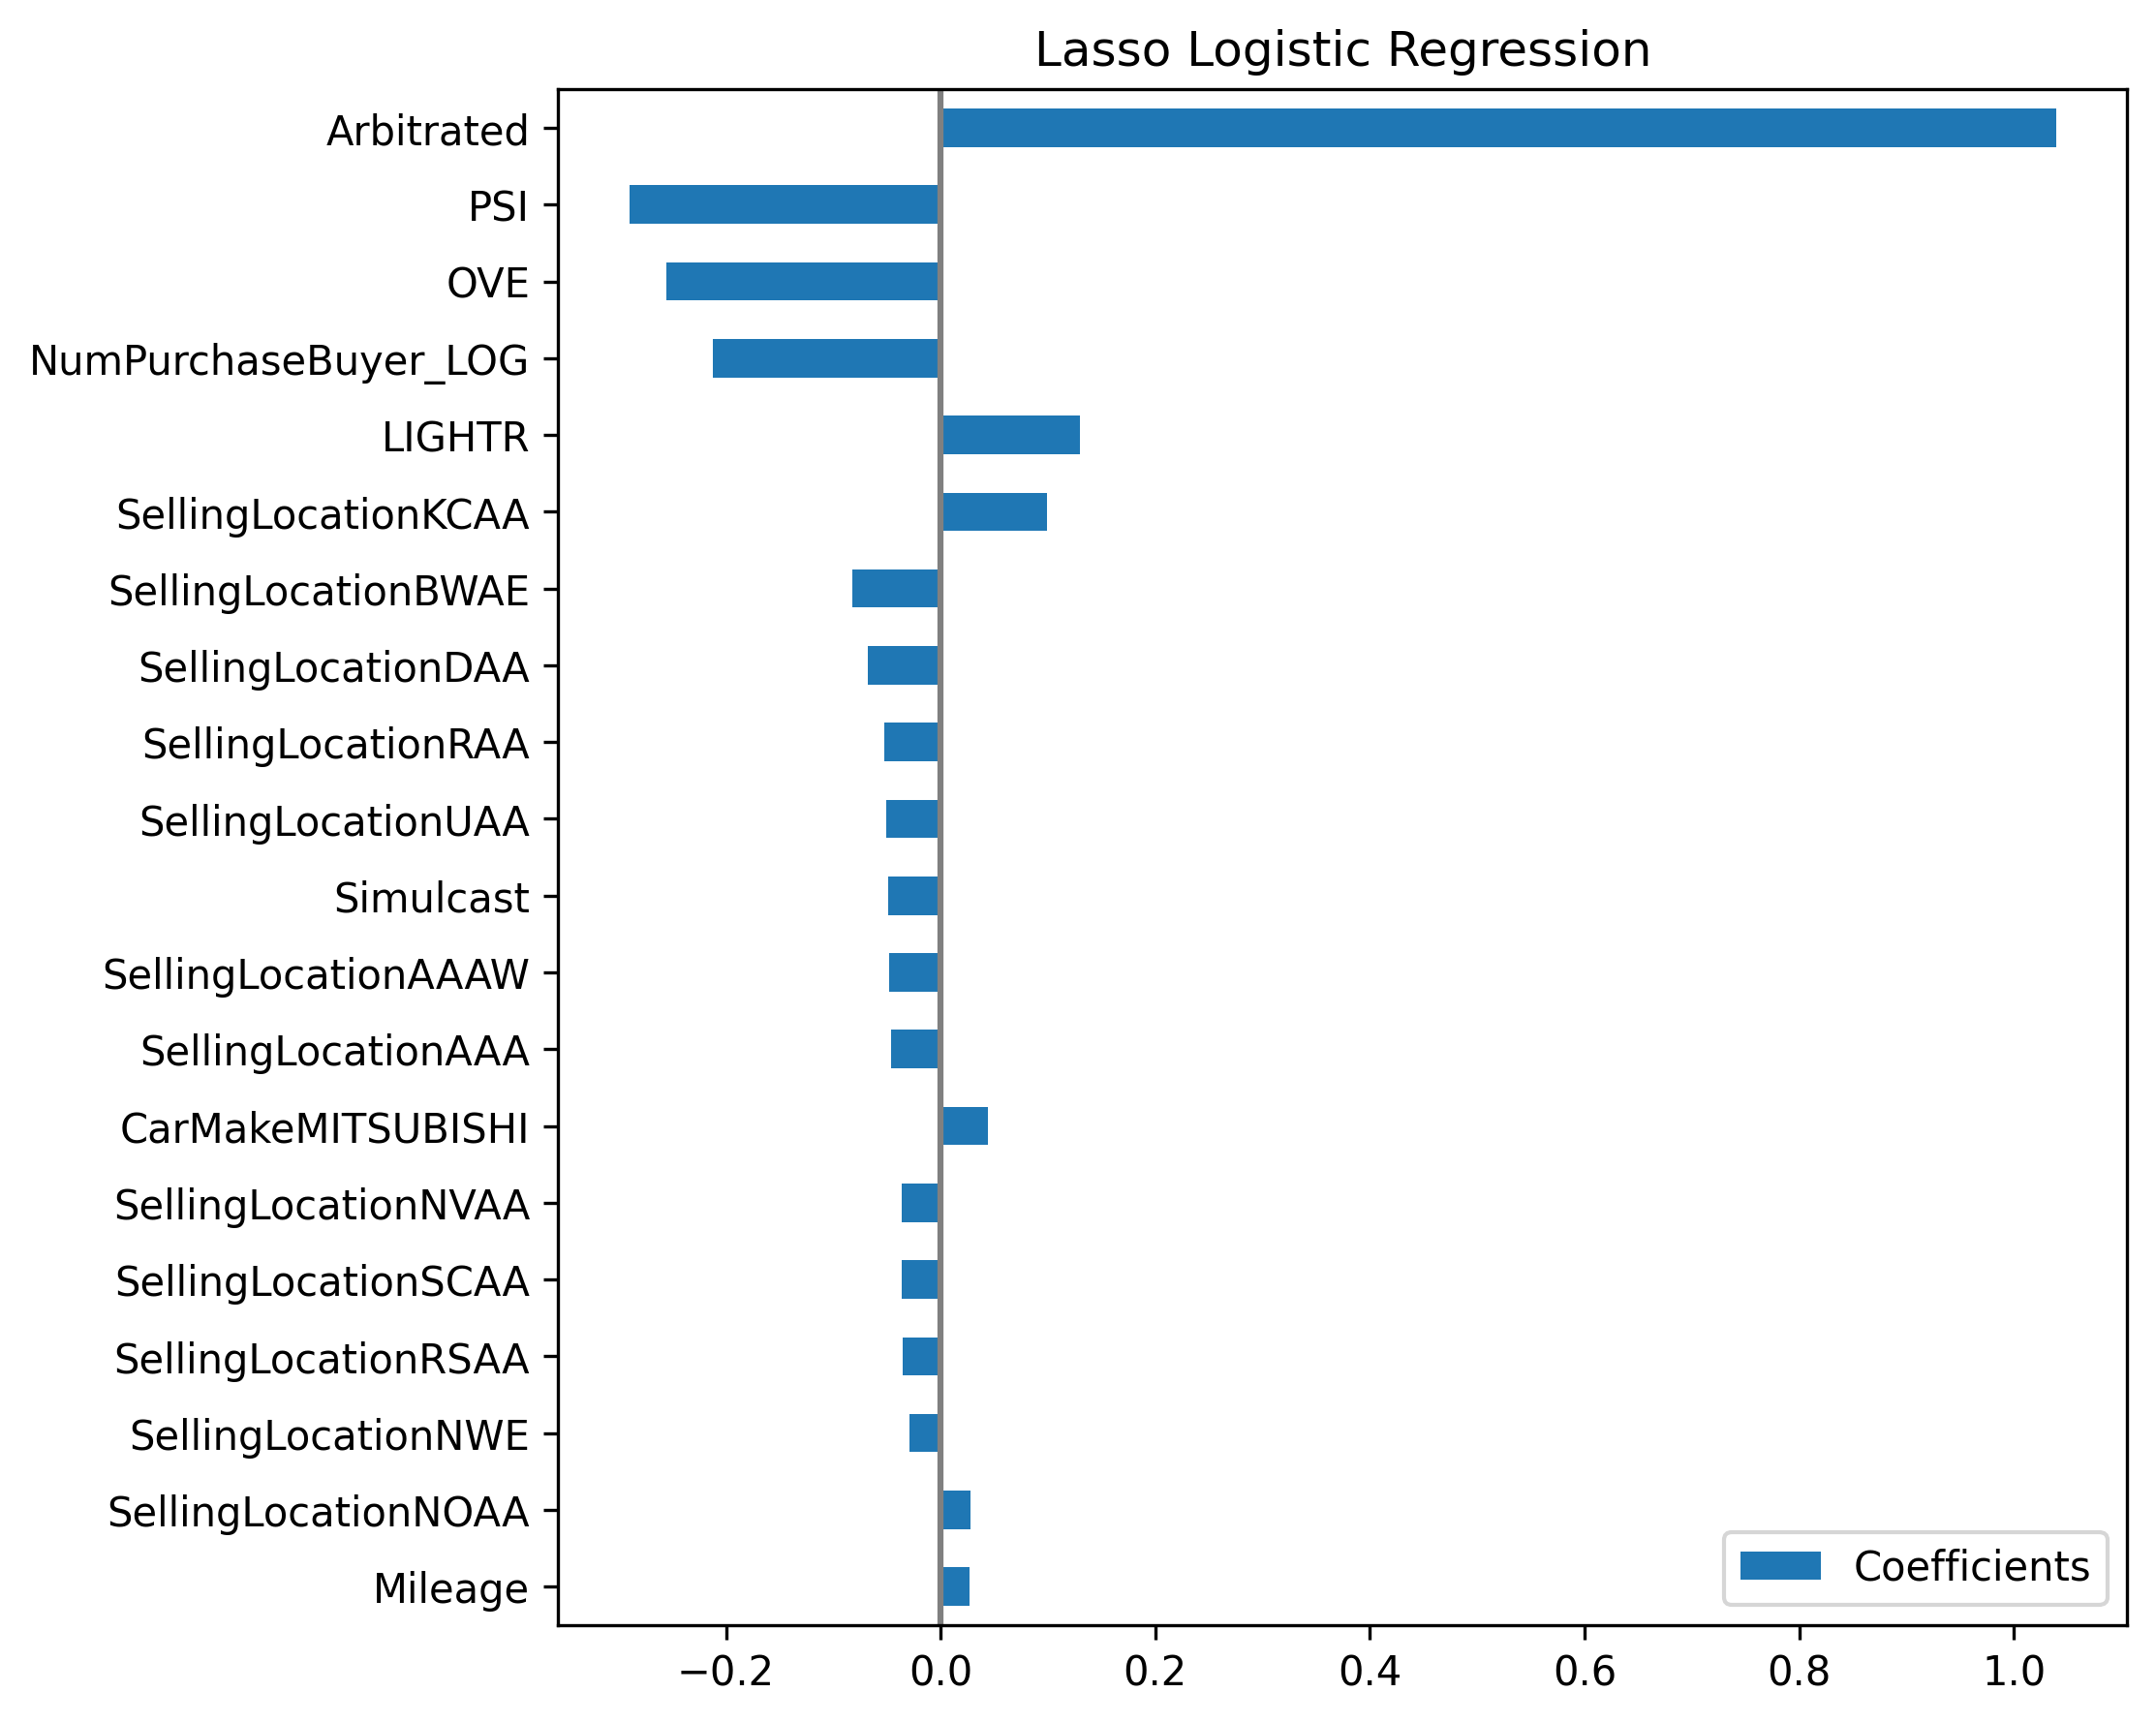

In [226]:
coefs[-20:].plot(kind='barh', figsize=(9, 7))
plt.title('Lasso Logistic Regression')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [16]:
df = df[df.columns.intersection(sel_feats)]

# Random Forest

In [5]:
### Build random forest model

from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [6]:
filepath = 'https://raw.githubusercontent.com/mh2t/RiskyDealer/main/case.csv'
df = pd.read_csv(filepath, sep=',')
#remove features not used for modeling
del df['BuyerID']
del df['Returned']
df = df.dropna(0)

In [7]:
df_y = df['Risky']
del df['Risky']

In [8]:
rfr = RandomForestClassifier(n_jobs=-1) 

In [9]:
### Split into training and test dataset
len_train = len(df)
x = df[:len_train]
y = df_y[:len_train]
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.4, random_state=2)
holdout_x = df[len_train:]
holdout_y = df_y[len_train:]

### hyper-parameter search

In [263]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [60, 80, 100, 120],
    'min_samples_leaf': [14,16,18],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [60, 100, 140, 180]
}
# Instantiate the grid search model
CV_rfr = GridSearchCV(estimator = rfr, param_grid = param_grid, cv = 5, n_jobs = -1)
CV_rfr.fit(train_x, train_y)
CV_rfr.best_params_

{'bootstrap': True,
 'max_depth': 60,
 'min_samples_leaf': 16,
 'min_samples_split': 10,
 'n_estimators': 60}

In [10]:
### Develop a random forest model with 'n_estimators' = best_estimators

print('random forest model is developing, it may take 10 minutes')
rfr_best = RandomForestClassifier(n_jobs=-1,n_estimators=70, min_samples_leaf=6, random_state=2) 
rfr_best.fit(train_x, train_y)

random forest model is developing, it may take 10 minutes


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

In [11]:
### Save the model in local disk

from sklearn.externals import joblib
joblib.dump(rfr_best, 'rforest.pkl')

['rforest.pkl']

In [14]:
### Evaluate the training AUC performance of the model
from sklearn.metrics import roc_auc_score

rfr_load = joblib.load('rforest.pkl')
print('random forest model is running')
train_y_pred = rfr_load.predict(train_x)
auc_train = roc_auc_score(train_y, train_y_pred)
print('Training AUC: ', auc_train)

random forest model is running
Training AUC:  0.9483455628417966


In [15]:
### Make prediction on test data
test_y_pred = rfr_load.predict(test_x)
auc_test = roc_auc_score(test_y, test_y_pred)
print('Testing AUC: ', auc_test)

Testing AUC:  0.7019182629012221


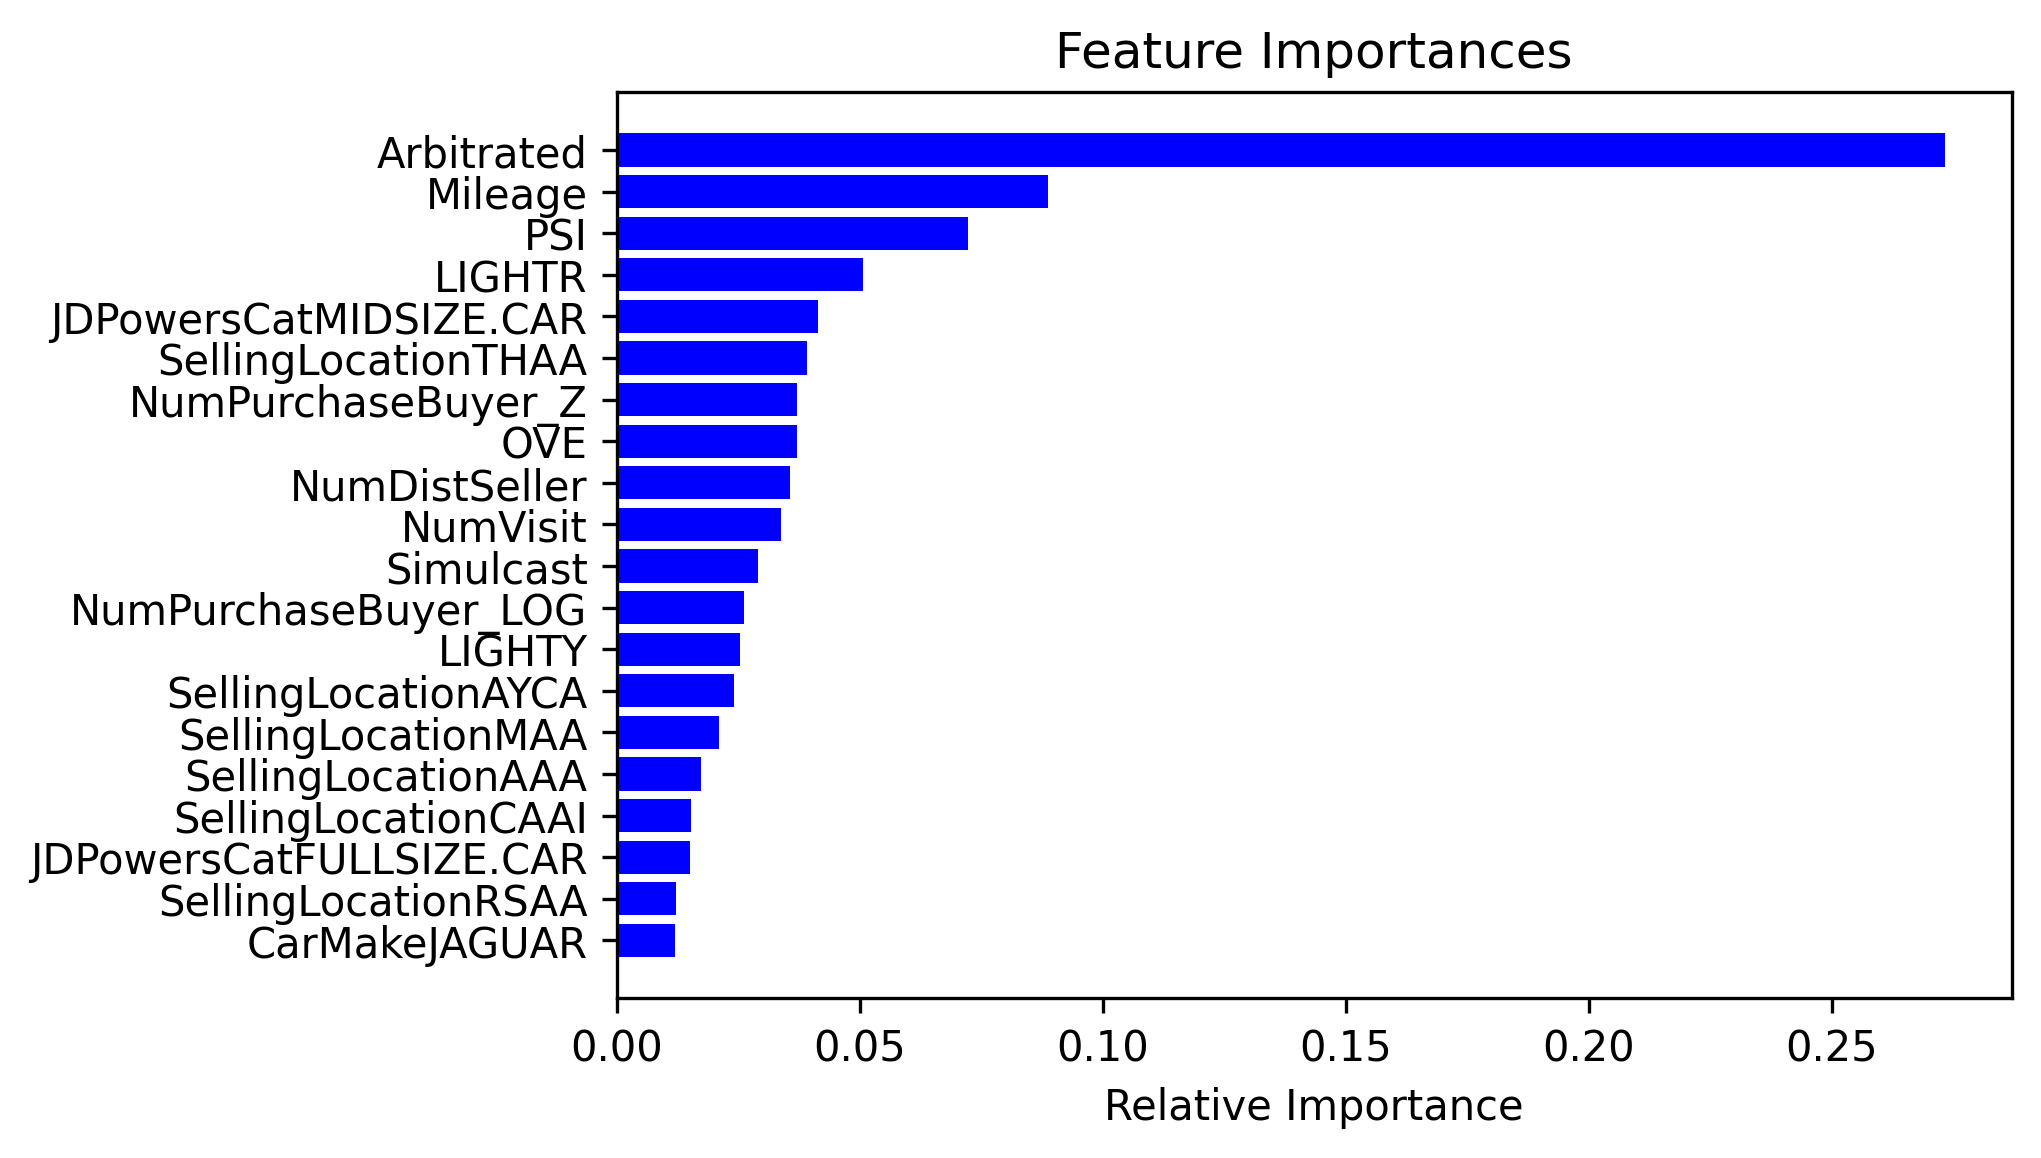

In [42]:
# original model
features = df.columns
importances = rfr_load.feature_importances_
indices = np.argsort(importances)[-20:]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### SHAP Explanation

In [43]:
import shap  
from shap import TreeExplainer
from shap import summary_plot

rf_exp = TreeExplainer(rfr_load)
rf_sv = np.array(rf_exp.shap_values(test_x))
rf_ev = np.array(rf_exp.expected_value)

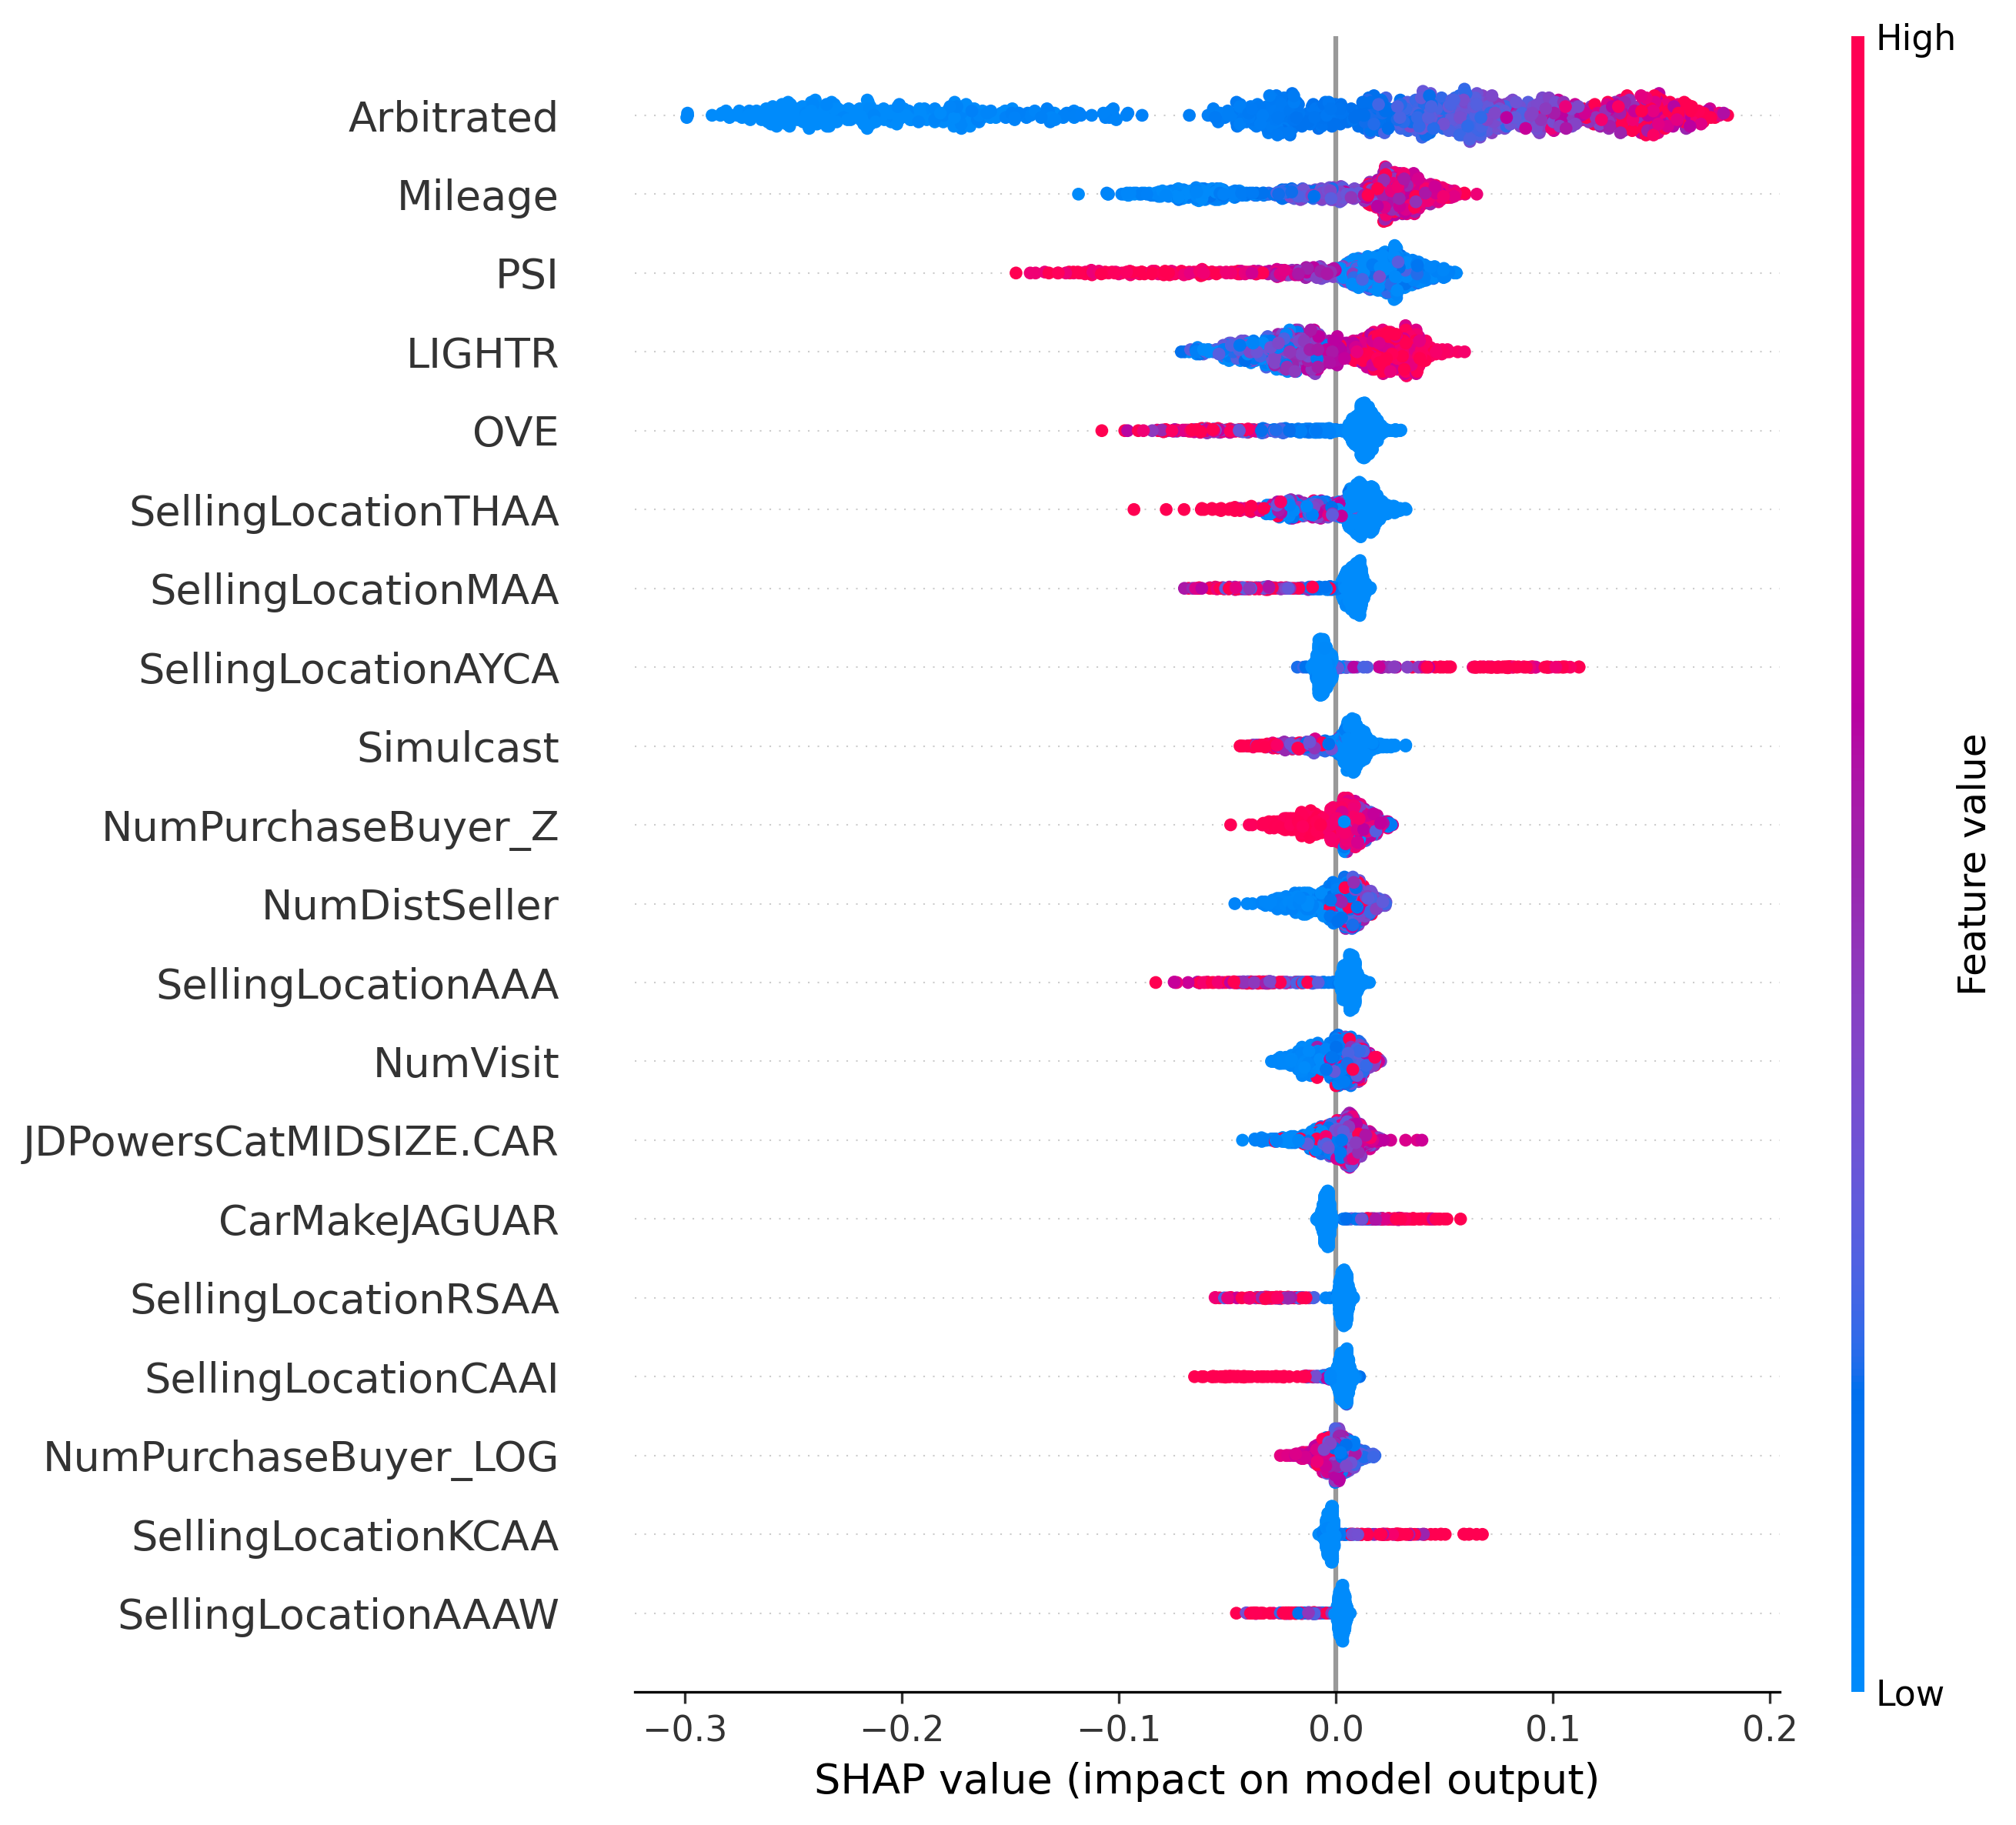

In [44]:
summary_plot(rf_sv[1],test_x)

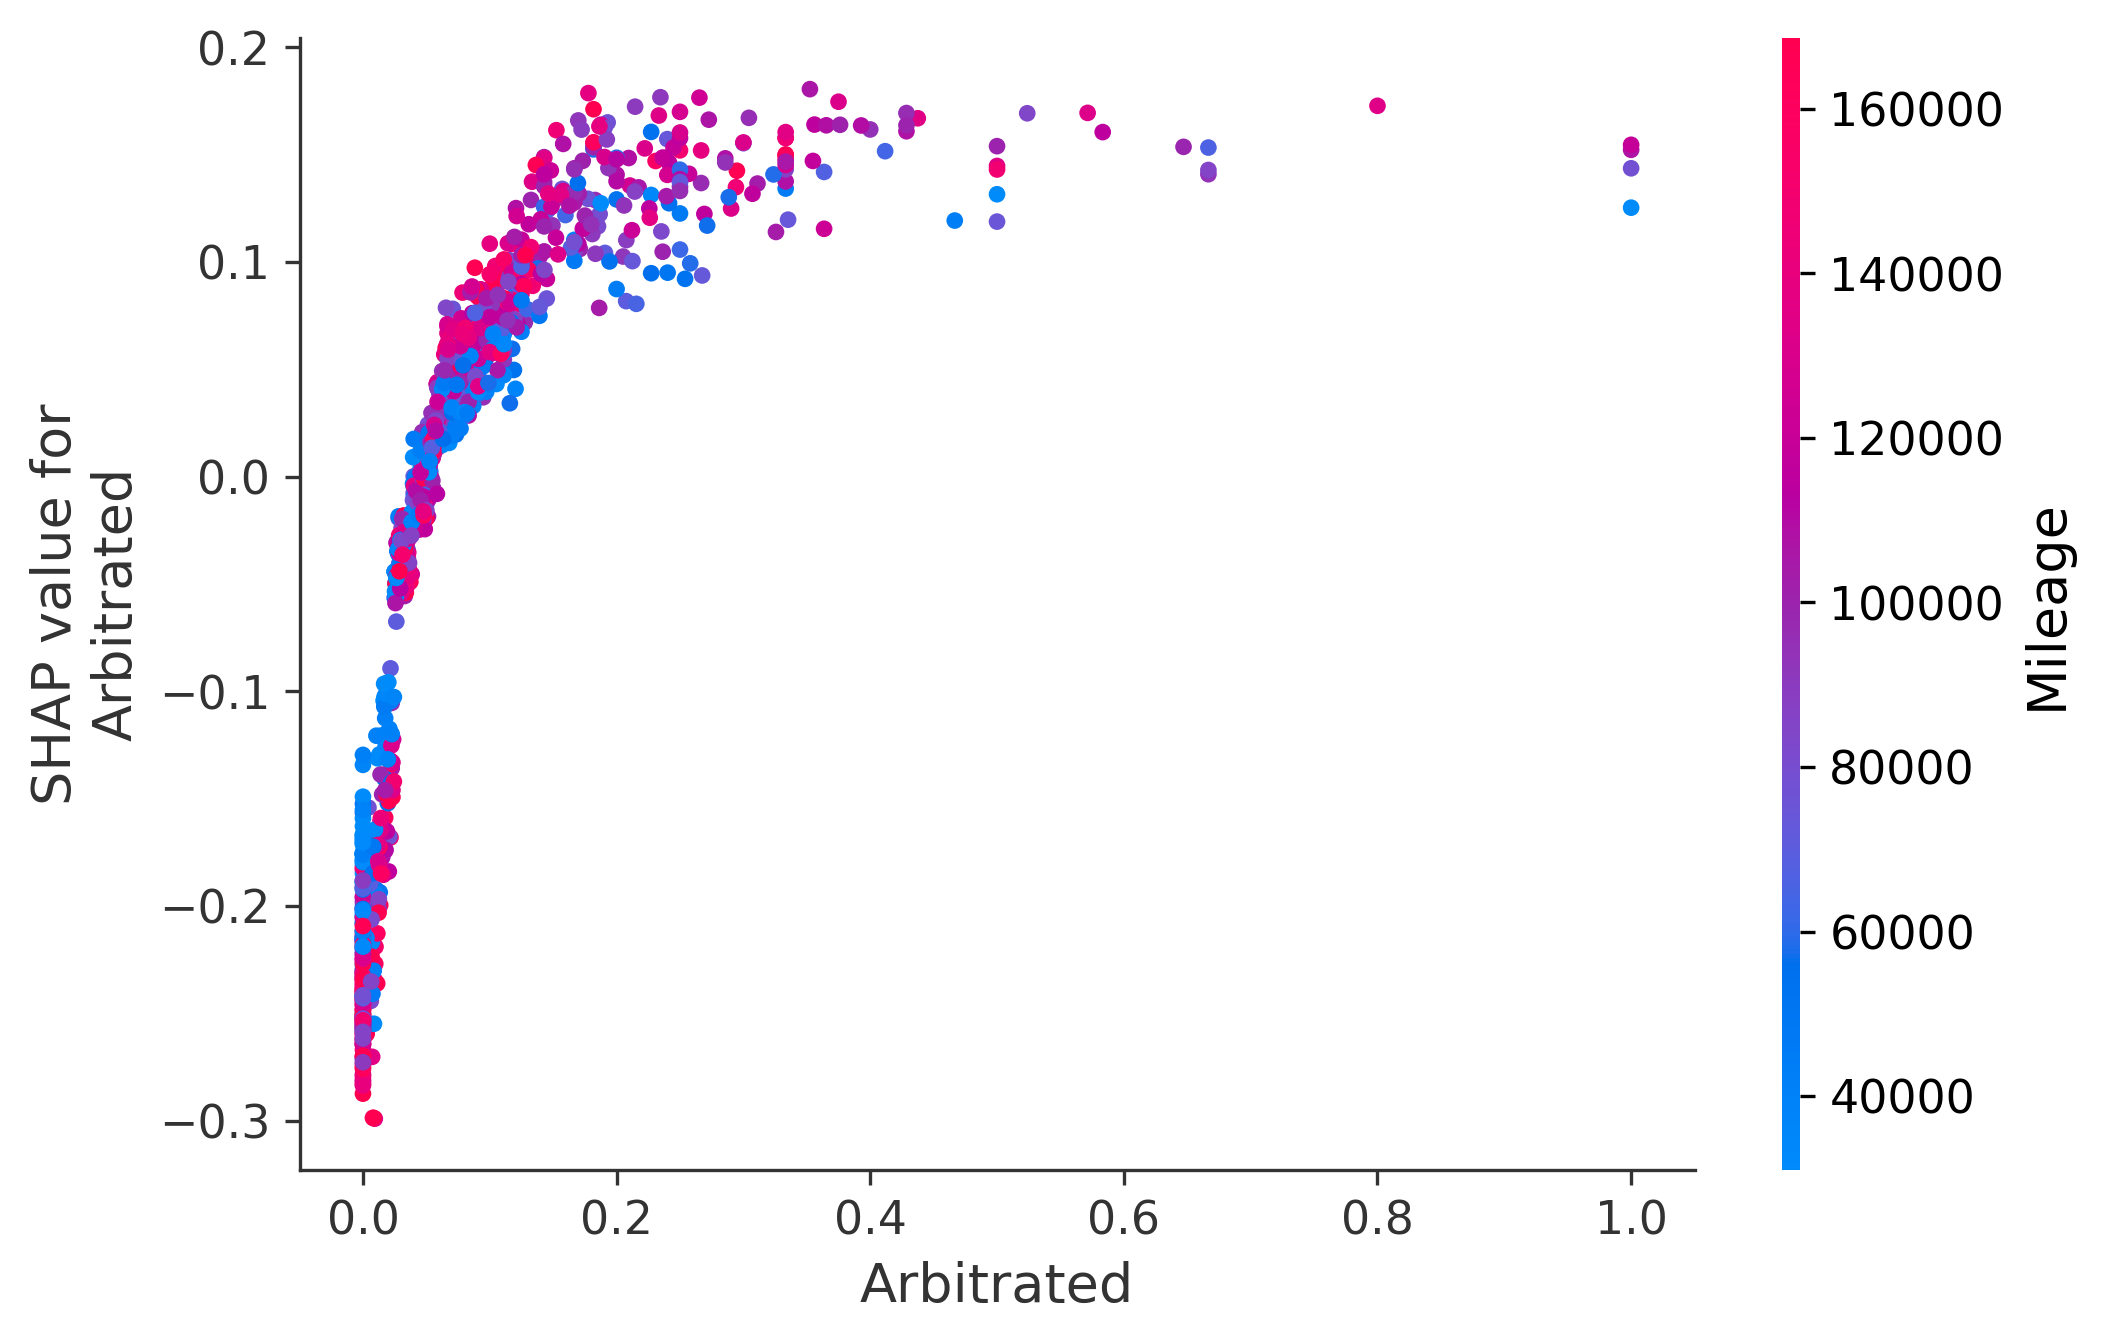

In [52]:
shap.dependence_plot("Arbitrated", rf_sv[1], test_x)

### LIME

In [53]:
def prob(data):
    return np.array(list(zip(1-rfr_load.predict(data),rfr_load.predict(data))))

explainer = lime.lime_tabular.LimeTabularExplainer(train_x.to_numpy(),feature_names=train_x.columns, mode='classification')

exp = explainer.explain_instance(test_x.iloc[400,:], prob, num_features=20)
exp.show_in_notebook(show_table=True)

In [56]:
def prob(data):
    return np.array(list(zip(1-rfr_load.predict(data),rfr_load.predict(data))))

explainer = lime.lime_tabular.LimeTabularExplainer(train_x.to_numpy(),feature_names=train_x.columns, mode='classification')

exp = explainer.explain_instance(test_x.iloc[390,:], prob, num_features=10)
exp.show_in_notebook(show_table=True)

###Scoring All Buyers

In [31]:
filepath = 'https://raw.githubusercontent.com/mh2t/RiskyDealer/main/case.csv'
dff = pd.read_csv(filepath, sep=',')

In [129]:
#remove features not used for modeling
df_sel = df[df.columns.intersection(sel_feats)]

In [130]:
df_sel.shape

(2349, 50)

In [213]:
rfr_load = joblib.load('rforest.pkl')
print('random forest model is running')
df_buyer = pd.DataFrame(rfr_load.predict(df))

random forest model is running


(0.0, 1.0)

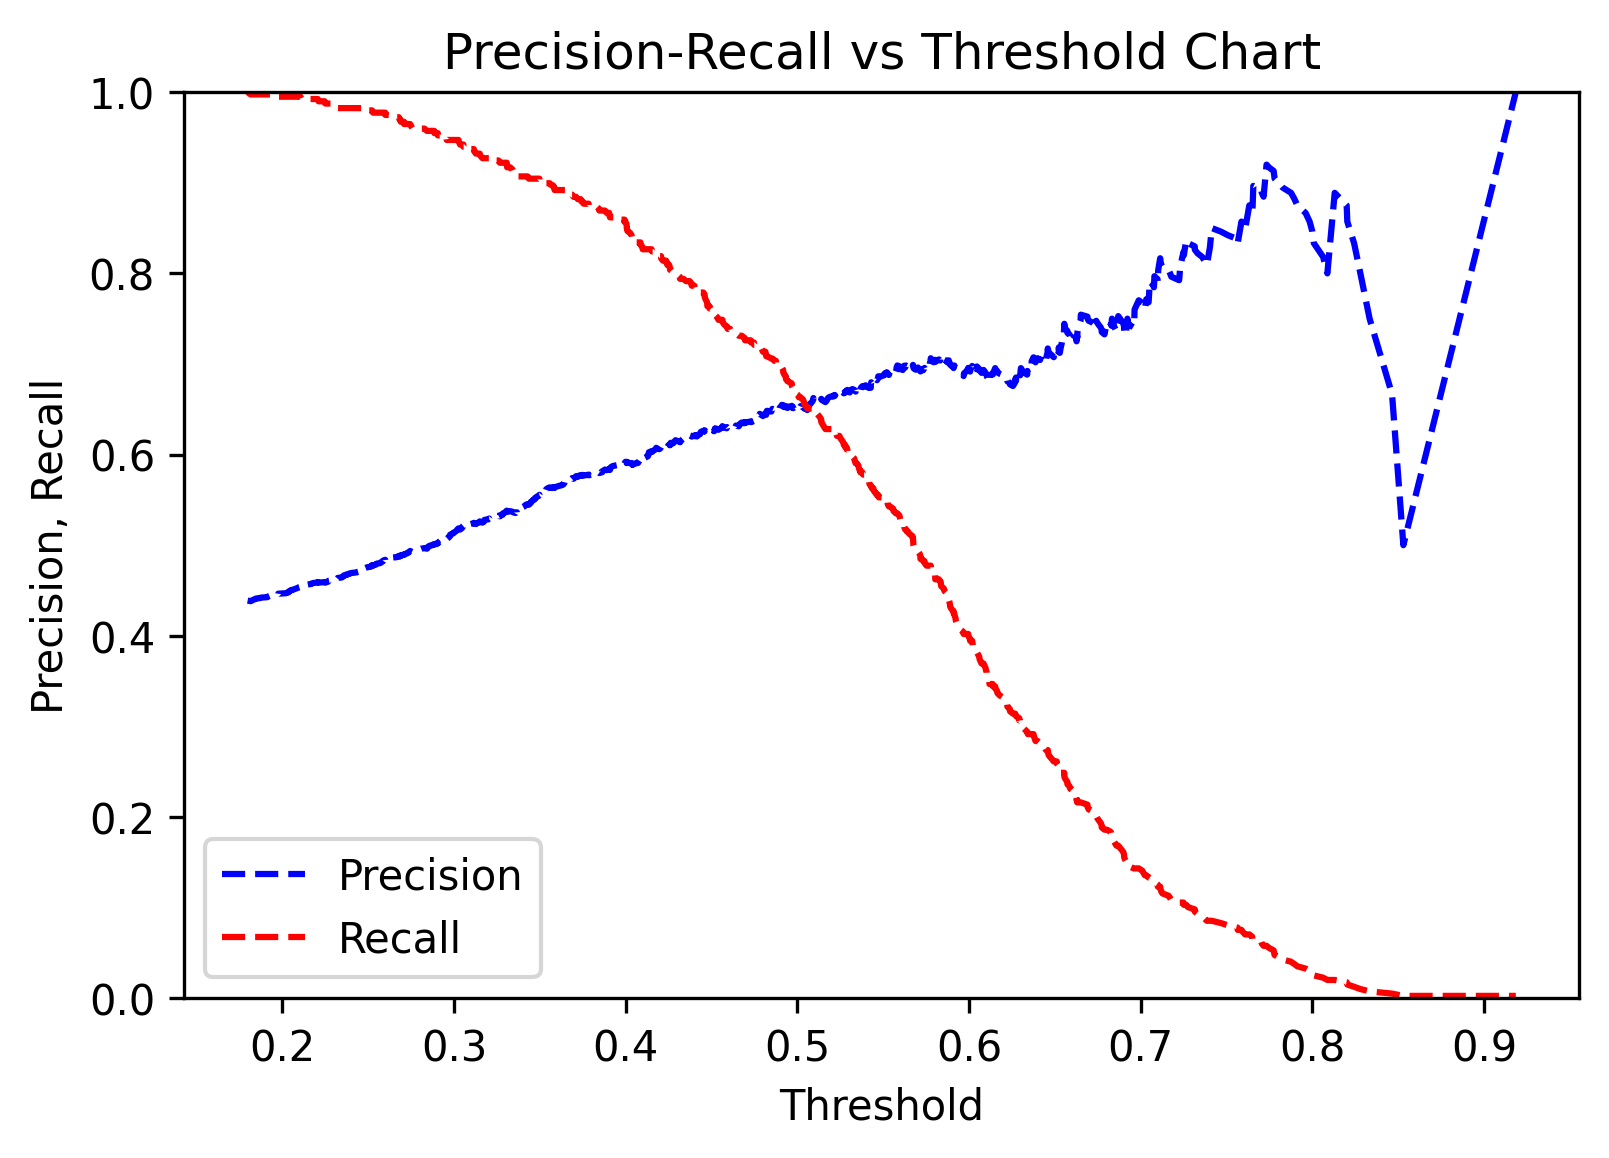

In [32]:
from sklearn.metrics import precision_recall_curve
probs_y=rfr_load.predict_proba(test_x) 
precision, recall, thresholds = precision_recall_curve(test_y, probs_y[:, 1]) 

pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [215]:
df_buyer = pd.concat([dff['BuyerID'].reset_index(drop=True), dff['Risky'],df_buyer], axis=1)
df_buyer.columns = ['BuyerID', 'Risky','Risky_hat']

In [216]:
df_buyer

BuyerID  Risky  Risky_hat
0         329    0.0        1.0
1         376    1.0        1.0
2         724    0.0        0.0
3         945    0.0        0.0
4        1187    1.0        1.0
...       ...    ...        ...
2344   351612    0.0        0.0
2345   351690    0.0        0.0
2346   351692    0.0        0.0
2347   351746    0.0        0.0
2348   351757    0.0        0.0

[2349 rows x 3 columns]